In [1]:
import os
import cv2
import glob
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
data_path = 'C:/Users/aman8/human_activity/test/sample_videos'

In [5]:
categoeries = os.listdir(data_path)
labels = [i for i in range(len(categoeries))]
label_dict = dict(zip(categoeries, labels))
#['archery', 'benchpress', 'boxing', 'cycling', 'golf', 'handstand', 'jugllingballs', 'playingcello', 'pushups', 'table_tennis', 'taichi', 'typing', 'weightlifting', 'writing_on_board', 'yo_yo']

In [6]:
print(label_dict)
print(categoeries)
print(labels)

{'archery': 0, 'benchpress': 1, 'boxing': 2, 'cycling': 3, 'golf': 4, 'handstand': 5, 'jugllingballs': 6, 'playingcello': 7, 'pushups': 8, 'table_tennis': 9, 'taichi': 10, 'typing': 11, 'weightlifting': 12, 'writing_on_board': 13, 'yo_yo': 14}
['archery', 'benchpress', 'boxing', 'cycling', 'golf', 'handstand', 'jugllingballs', 'playingcello', 'pushups', 'table_tennis', 'taichi', 'typing', 'weightlifting', 'writing_on_board', 'yo_yo']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [7]:
root_path = 'C:/Users/aman8/human_activity/test/frames'

In [8]:
folder_count = 0
img_size=244 # Dimensions of frames we want to reszie to height/width
frames = 60 # Number of frames we want to extract form a video

In [9]:
for items in categoeries: #looping over folders in categoeries
    path = os.path.join(root_path, items) 
    folder_path = os.path.join(data_path,items)
    img_names = os.listdir(folder_path) # Listing all files inside the directory
    os.mkdir(path)
    img_count= 0
    folder_count +=1
    
    for img_name in img_names:
            cap = cv2.VideoCapture(os.path.join(folder_path, img_name)) # Capcturing video and dividing it by frames
            success, image = cap.read()
            number_of_frames = 1
            
            while success:
                success, image = cap.read()
                if not success:
                    break
                resized = cv2.resize(image,(img_size,img_size))
                cv2.imwrite(path + '/' + items + str(img_count) + '.png' , resized) # Writing image into to specified class with its class name 
                img_count += 1
                if number_of_frames != -1 and number_of_frames == (len(range(frames))):
                    break
                number_of_frames +=1

In [10]:
classes = ['archery', 'benchpress', 'boxing', 'cycling', 'golf', 'handstand', 'jugllingballs', 'playingcello', 'pushups', 'table_tennis', 'taichi', 'typing', 'weightlifting', 'writing_on_board', 'yo_yo']

In [11]:
datapath = 'C:/Users/aman8/human_activity/test/frames'
data_labels = set(['archery', 'benchpress', 'boxing', 'cycling', 'golf', 'handstand', 'jugllingballs', 'playingcello', 'pushups', 'table_tennis', 'taichi', 'typing', 'weightlifting', 'writing_on_board', 'yo_yo'])
pathImg = list(paths.list_images(datapath))
data = []
labels = []

for image in pathImg:
    label = image.split(os.path.sep)[-2]
    images = cv2.imread(image)
    data.append(images)
    labels.append(label)

In [12]:
data = np.array(data)
labels = np.array(labels)

In [14]:
print("data :",data.shape)
print("labels :",labels.shape)

data : (9107, 244, 244, 3)
labels : (9107,)


In [15]:
lb = LabelBinarizer()
labels_bin = lb.fit_transform(labels)

In [16]:
(X_train ,X_test ,y_train ,y_test) = train_test_split(data,labels_bin,test_size=0.2,stratify=labels,random_state=42)

In [18]:
print("X_train :",X_train.shape)
print("X_test :",X_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

X_train : (7285, 244, 244, 3)
X_test : (1822, 244, 244, 3)
y_train : (7285, 15)
y_test : (1822, 15)


In [19]:
trainingAug = ImageDataGenerator(rotation_range=30,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode='nearest')

In [20]:
validationAug = ImageDataGenerator()
mean = np.array([123.68,116.779,103.939], dtype='float32')
trainingAug.mean = mean
validationAug.mean = mean

In [21]:
from keras.applications.resnet import ResNet50

from keras.layers import Input
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Flatten
from keras.layers.core import Dense

from keras.layers.core import Dropout
from keras.models import Model

In [22]:
baseModel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(244,244,3)))

In [23]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(512, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation='softmax')(headModel)
model = Model(inputs = baseModel.input, outputs=headModel)

for baseModelLayers in baseModel.layers:
    baseModelLayers.trainable = False

In [28]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

In [29]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

In [30]:
model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [32]:
history = model.fit_generator(
                              trainingAug.flow(X_train,y_train, batch_size=32),
                              steps_per_epoch= len(X_train) // 32,
                              validation_data=validationAug.flow(X_test,y_test),
                              validation_steps=len(X_test) // 32,
                              epochs = 20)

C:\Users\aman8\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
227/227 [==============================] - 159s 641ms/step - loss: 0.2485 - accuracy: 0.9320 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 2/20
227/227 [==============================] - 144s 635ms/step - loss: 0.0270 - accuracy: 0.9928 - val_loss: 0.0021 - val_accuracy: 0.9994
Epoch 3/20
227/227 [==============================] - 140s 615ms/step - loss: 0.0105 - accuracy: 0.9975 - val_loss: 1.6849e-04 - val_accuracy: 1.0000
Epoch 4/20
227/227 [==============================] - 141s 621ms/step - loss: 0.0284 - accuracy: 0.9912 - val_loss: 3.5717e-04 - val_accuracy: 1.0000
Epoch 5/20
227/227 [==============================] - 145s 639ms/step - loss: 0.0215 - accuracy: 0.9945 - val_loss: 6.9514e-05 - val_accuracy: 1.0000
Epoch 6/20
227/227 [==============================] - 132s 581ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 8.1063e-05 - val_accuracy: 1.0000
Epoch 7/20
227/227 [==============================] - 141s 622ms/step - loss: 0.0187 - accuracy: 0.9941 - va

In [34]:
model.save('resnet50.hdf5')

C:\Users\aman8\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


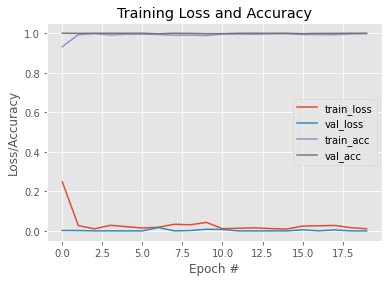

In [35]:
# plot the training loss and accuracy
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")